In [0]:
# Load pickled data
import numpy as np
from skimage import color, exposure, transform
from skimage import io
import os
import glob

from keras.models import Sequential

from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPool2D

from keras.callbacks import LearningRateScheduler, ModelCheckpoint

from keras.optimizers import SGD

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import tensorflow as tf
print(tf.__version__)

### Function for data preprocessing

In [0]:
def preprocess_img(img):
    # Histogram normalization in v channel
    hsv = color.rgb2hsv(img)
    hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
    img = color.hsv2rgb(hsv)

    # central square crop
    min_side = min(img.shape[:-1])
    centre = img.shape[0] // 2, img.shape[1] // 2
    img = img[centre[0] - min_side // 2:centre[0] + min_side // 2,
              centre[1] - min_side // 2:centre[1] + min_side // 2,
              :]

    # rescale to standard size
    img = transform.resize(img, (48, 48))

    # roll color axis to axis 0
    img = np.rollaxis(img, -1)

    return img

In [0]:
def get_class(img_path):
    return int(img_path.split('/')[-2])

### Load the training dataset

In [0]:
train_root_dir = '/content/training/GTSRB/Final_Training/Images'
train_imgs = []
train_labels = []

all_img_paths = glob.glob(os.path.join(train_root_dir, '*/*.ppm'))
np.random.shuffle(all_img_paths)
for img_path in all_img_paths:
    img = preprocess_img(io.imread(img_path))
    label = get_class(img_path)
    train_imgs.append(img)
    train_labels.append(label)

X_train = np.array(train_imgs, dtype='float32')
# Make one hot targets
Y_train = np.eye(43, dtype='uint8')[train_labels]

In [11]:
Y_train.shape

(39209, 43)

In [15]:
X_train.shape

(39209, 3, 48, 48)

### Load the testing data

In [0]:
test = pd.read_csv('testing/GT-final_test.csv', sep=';')

In [0]:
# Load test dataset
X_test = []
y_test = []
i = 0
for file_name, class_id in zip(list(test['Filename']), list(test['ClassId'])):
    img_path = os.path.join('testing/GTSRB/Final_Test/Images/', file_name)
    X_test.append(preprocess_img(io.imread(img_path)))
    y_test.append(class_id)

In [0]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [19]:
X_test.shape

(12630, 3, 48, 48)

### Create the model

In [0]:
input_shape = (48, 48, 3)

In [21]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), padding='same', input_shape=input_shape, activation='relu'))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)       

### Compile the model

In [0]:
# let's train the model using SGD + momentum
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

### Fit the data into the model

In [0]:
def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

In [0]:
batch_size = 32
epochs = 30

In [0]:
X_train = X_train.reshape(X_train.shape[0], 48, 48, 3)

In [27]:
model_history = model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=[LearningRateScheduler(lr_schedule),
                     ModelCheckpoint('model.h5', save_best_only=True)],
          verbose=2
          )

Train on 31367 samples, validate on 7842 samples
Epoch 1/30
 - 17s - loss: 3.2347 - accuracy: 0.1196 - val_loss: 2.3352 - val_accuracy: 0.3049
Epoch 2/30
 - 9s - loss: 1.0439 - accuracy: 0.6681 - val_loss: 0.3182 - val_accuracy: 0.8929
Epoch 3/30
 - 9s - loss: 0.3481 - accuracy: 0.8882 - val_loss: 0.1477 - val_accuracy: 0.9528
Epoch 4/30
 - 9s - loss: 0.1964 - accuracy: 0.9375 - val_loss: 0.1038 - val_accuracy: 0.9679
Epoch 5/30
 - 9s - loss: 0.1351 - accuracy: 0.9573 - val_loss: 0.0836 - val_accuracy: 0.9719
Epoch 6/30
 - 10s - loss: 0.1056 - accuracy: 0.9674 - val_loss: 0.0575 - val_accuracy: 0.9807
Epoch 7/30
 - 10s - loss: 0.0908 - accuracy: 0.9720 - val_loss: 0.0513 - val_accuracy: 0.9824
Epoch 8/30
 - 9s - loss: 0.0755 - accuracy: 0.9765 - val_loss: 0.0601 - val_accuracy: 0.9821
Epoch 9/30
 - 9s - loss: 0.0704 - accuracy: 0.9794 - val_loss: 0.0372 - val_accuracy: 0.9890
Epoch 10/30
 - 9s - loss: 0.0551 - accuracy: 0.9821 - val_loss: 0.0408 - val_accuracy: 0.9894
Epoch 11/30
 - 10

### Plot the training accuracy

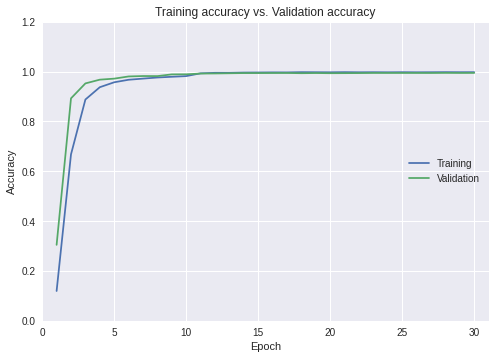

In [28]:
matplotlib.style.use('seaborn')
epochs = len(model_history.history['accuracy'])
plt.axis([0, epochs+1, 0, 1.2])
x = np.arange(1, epochs+1)
plt.plot(x, model_history.history['accuracy'])
plt.plot(x, model_history.history['val_accuracy'])
plt.title('Training accuracy vs. Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()

### plot the training loss

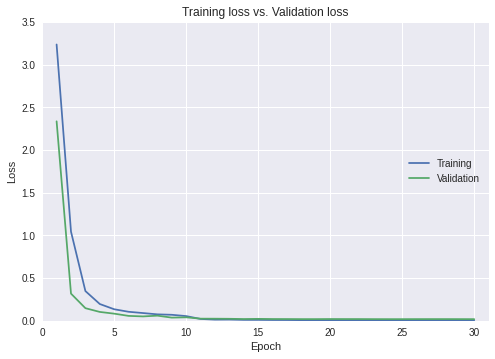

In [29]:
matplotlib.style.use('seaborn')
epochs = len(model_history.history['loss'])
max_loss = max(max(model_history.history['loss']), max(model_history.history['val_loss']))
plt.axis([0, epochs+1, 0, round(max_loss * 2.0) / 2 + 0.5])
x = np.arange(1, epochs+1)
plt.plot(x, model_history.history['loss'])
plt.plot(x, model_history.history['val_loss'])
plt.title('Training loss vs. Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()

### Evaluate the model

In [0]:
X_test = X_test.reshape(X_test.shape[0], 48, 48, 3)

In [67]:
# predict and evaluate
y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred == y_test) / np.size(y_pred)
print("Test accuracy = {}".format(acc))

Test accuracy = 0.9566904196357878


### Predition test

In [0]:
from tensorflow.keras.models import load_model
from imutils import paths
import numpy as np
import argparse
import imutils
import random
#from utils import *
import cv2
import os

In [0]:
!mkdir test_image

Predicted sign: [38]


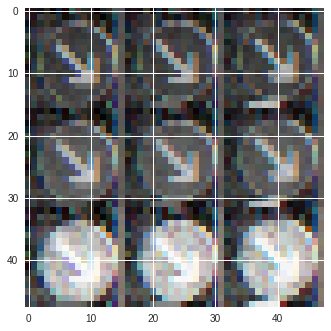

In [81]:
plt.imshow(X_test[400].reshape(48, 48, 3))
print("Predicted sign: "+ str( 
        model.predict_classes(X_test[400].reshape(1, 48, 48, 3))))